In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
import gc
from sklearn.metrics import roc_auc_score

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, \
    get_context_length, get_generated_text, FileReader, is_text_in_language, rolling_mean

from src.attention_saver import Mistral7BAttentionSaver
from src.influence.influence import Influence, AttentionRollout

import scienceplots
plt.style.use(['science','no-latex'])

tqdm.pandas()

## Loading dataset

In [3]:
notebook_login()

In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)


base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    quantization_config = quantization_config,
    device_map="auto",
    attn_implementation="eager",
    cache_dir = "/Data"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

df = load_dataset("stas/openwebtext-10k", cache_dir= "/Data")['train'].to_pandas()
df["text_len"] = df["text"].apply(lambda x: len(x.split(" ")))
df["context_length"] = df['text'].progress_apply(get_context_length, tokenizer = tokenizer)

100%|██████████| 10000/10000 [00:13<00:00, 716.58it/s]


In [6]:
samples = df.query("context_length > 3500 & context_length < 4000")\
    .sample(5, random_state=42)

samples["instruction"] = "Summarize in French: "
samples['prompt'] = samples["instruction"] + "\n" + samples['text']

In [7]:
influence_calculator = Influence(
    base_model,
    tokenizer,
    32
)

influence_mistral = influence_calculator(
    samples.reset_index(),
    0,
    text_col="prompt"
)

5 12
Forward propagation on instruction = Summarize in French: . Index = 4
Influence tokens : 5 to 12
Studying influence to 'Summarize in French: '
Finished forward step in 7.507514476776123 s


100%|██████████| 32/32 [00:00<00:00, 115.09it/s]


Passing tensors to CPU...


In [8]:
tokenizer_llama = AutoTokenizer.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    cache_dir = "/Data"    
)


base_model_llama = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    quantization_config = quantization_config,
    device_map="auto",
    attn_implementation="eager",
    cache_dir = "/Data"
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
influence_calculator_llama = Influence(
    base_model_llama,
    tokenizer_llama,
    32
)

influence_llama = influence_calculator_llama(
    samples.reset_index(),
    0,
    text_col="prompt"
)

5 12
Forward propagation on instruction = Summarize in French: . Index = 4
Influence tokens : 5 to 12
Studying influence to 'Summarize in French: '


Finished forward step in 6.025365352630615 s


100%|██████████| 32/32 [00:00<00:00, 143.71it/s]


Passing tensors to CPU...


In [21]:
influences_llama_df = pd.DataFrame(influence_llama).T
influences_llama_df["model"] = "llama"

influences_mistral_df = pd.DataFrame(influence_mistral).T
influences_mistral_df ["model"] = "mistral"

influences_df = pd.concat([influences_llama_df, influences_mistral_df])

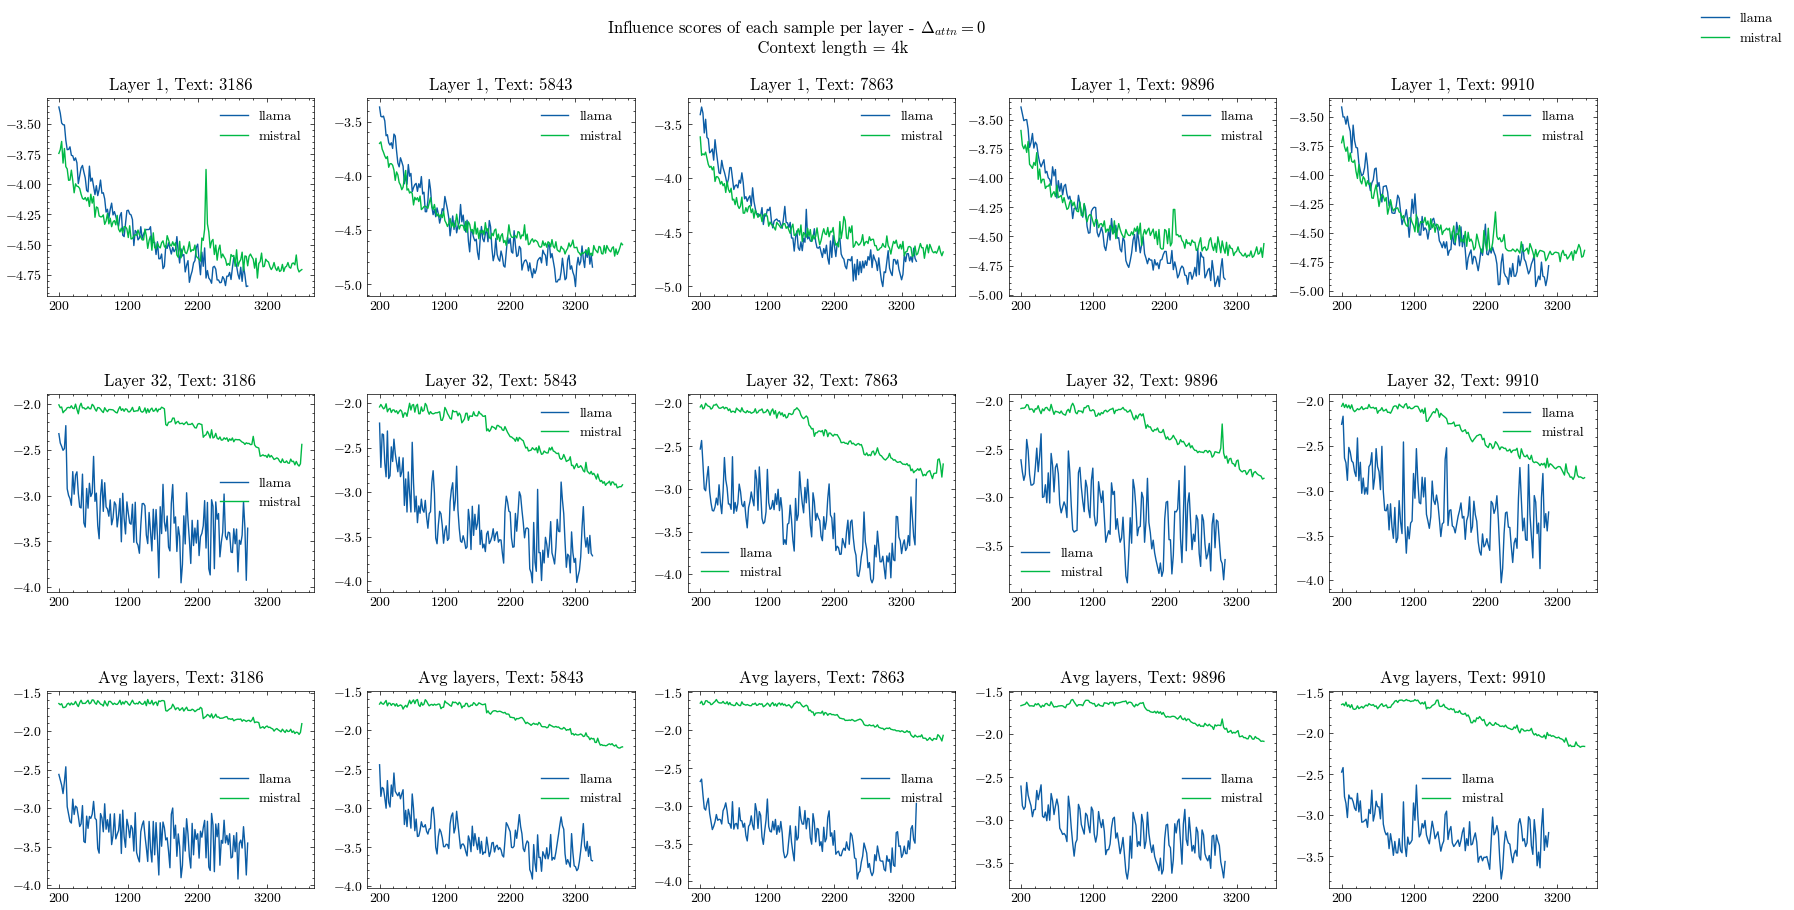

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

text_id_keymap = {k: i for (i,k) in enumerate(sorted(samples.index.unique()))}
layer_id_keymap = {0:0, 15: 1, 31: 2}


for id, (text_id, res) in enumerate((influences_df).iterrows()):
    influences = res['influences']
    model = res['model']

    influence_0 = influences[0]
    influence_15 = influences[15]
    influence_31 = influences[31]

    text_id, instruction = text_id

    ax_idx = text_id_keymap[text_id]


    axes[0][ax_idx].plot(
        torch.log10(rolling_mean(influence_0, 20)[10:]),
        label = model,
        # label = instruction,
    )


    axes[1][ax_idx].plot(
        torch.log10(rolling_mean(influence_15, 20)[10:]),
        label = model,
        # label = instruction,
    )


    axes[2][ax_idx].plot(
        torch.log10(rolling_mean(influence_31, 20)[10:]),
        label = model,
    )

    axes[0][ax_idx].set_title(f"Layer 1, Text: {text_id}")
    axes[1][ax_idx].set_title(f"Layer 32, Text: {text_id}")
    axes[2][ax_idx].set_title(f"Avg layers, Text: {text_id}")

    xticks = axes[0][ax_idx].get_xticks()
    new_xticks = xticks * 20 + 200

    # Set the new x-tick labels
    axes[0][ax_idx].set_xticklabels(new_xticks.astype(int))
    axes[1][ax_idx].set_xticklabels(new_xticks.astype(int))
    axes[2][ax_idx].set_xticklabels(new_xticks.astype(int))


    axes[0][ax_idx].legend()
    axes[1][ax_idx].legend()
    axes[2][ax_idx].legend()





    
        # axes[layer_id][id].set_title(f"Layer {layer}, Text: {text_id}")
        # axes[layer_id][id].grid(True)

        # xticks = axes[layer_id][id].get_xticks()
        # new_xticks = xticks * 20 + 400

        # # Set the new x-tick labels
        # axes[layer_id][id].set_xticklabels(new_xticks.astype(int))
        # axes[layer_id][id].set_xlabel("context length")
        # axes[layer_id][id].set_ylim([-10, -5])
handles, labels = axes[-1][-1].get_legend_handles_labels()

fig.suptitle(r'''Influence scores of each sample per layer - $\Delta_{attn} = 0$ 
             Context length = 4k''')


fig.subplots_adjust(top=0.9)
fig.subplots_adjust(hspace=0.5)

fig.legend(handles, labels)